# Steady-state conduction in an insulated rod with internal heat production

<p style="font-size:10px">This work is licensed under the Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0) license.</p>

Kamila Zdybał, 2020

<p style="font-size:10px">Université libre de Bruxelles, kamila.zdybal@ulb.ac.be</p>
<p style="font-size:10px"><a href="https://camillejr.github.io/science-docs/">Science Docs</a>, kamila.zdybal@gmail.com</p>

***

In this notebook we present the code behind the tutorial that can be accessed [here](https://github.com/camillejr/fluid-dynamics-and-transport-phenomena/blob/master/transport-phenomena-with-Python/example-heat-transfer-in-a-rod.pdf).

The governing ODE for this problem:

$$\frac{d^2 T}{dx^2} = - \frac{Q_p}{\lambda}$$

We start with computing the analytic solution and then compare that with two numerical solutions: using *Finite Difference Method* (FDM) and *Finite Volume Method* (FVM).

***

In [1]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import math
import numpy as np

# Set some initial parameters:
fontsize_labels = 20
fontsize_axes = 16
fontsize_text = 16
save_plots = True
line_color = '#0e2f44'
FDM_color = '#4fb49d'
FVM_color = '#d57211'
bar_color = '#767676'
help_lines = "#e5e5e5"

# Fonts:
csfont = {'fontname':'Charter', 'fontweight':'regular'}
hfont = {'fontname':'Charter', 'fontweight':'bold'}

# Function for plotting the solution:
def plot_solution(x, T, x_approx=[], T_approx=[], approx_color=''):

    figure = plt.figure(figsize=(15, 5))
    ax1 = figure.add_subplot(1,1,1)
    plt.plot(x, T, color=line_color, linestyle='-', linewidth=2.0, zorder=1)
    if len(x_approx) != 0:
        plt.plot(x_approx, T_approx, color=approx_color, marker='o', markersize=10, linestyle='-', linewidth=2.0, zorder=1)
    plt.xlabel(r'x [m]', fontsize=fontsize_labels, **csfont)
    plt.ylabel(r'T(x) [$^o C$]', fontsize=fontsize_labels, **csfont)
    plt.xlim(-0.05*L, 1.05*L)
    plt.ylim(-0.15*max(T), 1.1*max(T))
    ax1.spines["top"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["left"].set_visible(False)
    ax1.margins(x=0)
    plt.rcParams['axes.xmargin'] = 0

    ax1.add_patch(
        patches.Rectangle(
            (0, -0.1*max(T)),
            L,
            0.1*max(T),
            Fill=False,
            edgecolor=bar_color,
            linewidth=1,
            hatch='\\'))
    
    for label in (ax1.get_xticklabels()):
        label.set_fontname('Charter')
        label.set_fontweight('regular')
        label.set_fontsize(fontsize_axes)

    for label in (ax1.get_yticklabels()):
        label.set_fontname('Charter')
        label.set_fontweight('regular')
        label.set_fontsize(fontsize_axes)

    for y in np.arange(min(T), 1.1*max(T), 50):
        plt.plot([-0.05*L, 1.05*L], [y, y], "-", lw=1, color=help_lines, zorder=-1, alpha=0.4)

***

## Analytic solution

We begin with plotting the analytic solution:

$$T(x) = - \frac{Q_p}{2 \lambda} (x^2 - Lx) + T_0$$

First, let's set the data for this exercise:

In [2]:
T0 = 0       # deg C
L = 200      # m
A = 0.01     # m^2 
Q = 20       # W
Qp = Q/(L*A) # W/m^3
𝝀 = 400      # W/(m*C)

# Discretize the rod:
n_points = 200
x = np.linspace(0, L, n_points)

# Analytic solution:
T = - Qp/(2*𝝀) * (x**2 - L * x) + T0

Plot the analytic solution:

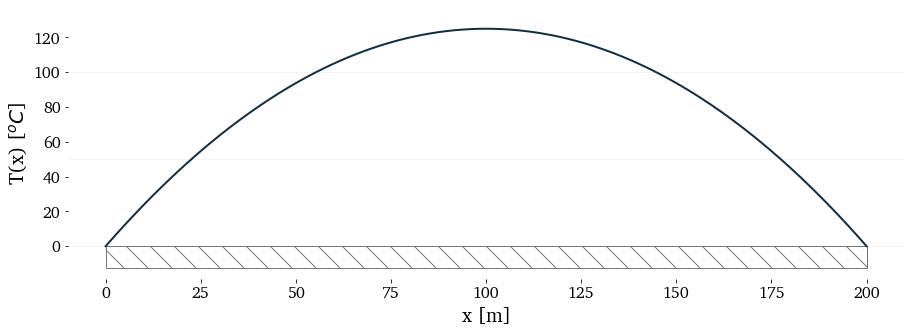

In [3]:
plot_solution(x, T)
if save_plots==True: plt.savefig('../plots/example-heat-transfer-in-a-rod-analytic.png', dpi = 500, bbox_inches='tight')

***

## Numerical solutions

We are going to solve a second-order linear ODE:

$$\frac{d^2 T}{dx^2} = - \frac{Q_p}{\lambda}$$

with two Dirichlet boundary conditions: $T(x=0) = T_0$ and $T(x=L) = T_0$.

### Finite Difference Method (FDM)

Using the second-order central difference approximation we have:

$$\frac{T_{i-1} - 2 T_i + T_{i+1}}{\Delta x^2} = - \frac{Q_p}{\lambda}$$

which we can also write as:

$$T_{i-1} - 2 T_i + T_{i+1} = - \Delta x^2 \frac{Q_p}{\lambda}$$

to have a better view for creating the matrix form of the system of equations. Having selected `n_points` that discretize the domain, we have $n$=`n_points` equations to solve.

In a matrix form those can be written as:

\begin{gather}
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & \dots & 0 \\
1 & -2 & 1 & 0 & 0 & \dots & 0 \\
0 & 1 & -2 & 1 & 0 & \dots & 0 \\
\vdots \\
0 & 0 & 0 & 0 & 0 & \dots & 1 \\
\end{bmatrix}
\begin{bmatrix}
T_1  \\
T_2 \\
T_2 \\
\vdots \\
T_n \\
\end{bmatrix}
=
\begin{bmatrix}
T_0  \\
- \Delta x^2 \frac{Q_p}{\lambda} \\
- \Delta x^2 \frac{Q_p}{\lambda} \\
\vdots \\
T_0 \\
\end{bmatrix}
\end{gather}

Or in general as: $\mathbf{A} \mathbf{T} = \mathbf{R}$. Notice that the matrix $\mathbf{A}$ is a tridiagonal matrix. We will use that information to construct that matrix using `np.diag()` methods.

In [4]:
def solve_with_fdm(n):
    
    dx = L/(n-1)

    # Construct three diagonals:
    upper_diagonal = np.ones(n-1)
    diagonal = - 2*np.ones(n)
    lower_diagonal = np.ones(n-1)

    # Set the boundary conditions:
    upper_diagonal[0] = 0
    diagonal[0] = 1
    diagonal[-1] = 1
    lower_diagonal[-1] = 0
    
    # Construct the matrix A from the three diagonals:
    A = np.diag(lower_diagonal, -1) + np.diag(diagonal, 0) + np.diag(upper_diagonal, 1)
    
    # Construct the right-hand-side matrix:
    R = np.ones(n) * (-dx**2*(Qp/𝝀))
    
    # Set the boundary conditions:
    R[0] = T0
    R[-1] = T0

    # Solve system of equations:
    T = np.linalg.solve(A, R)

    return T

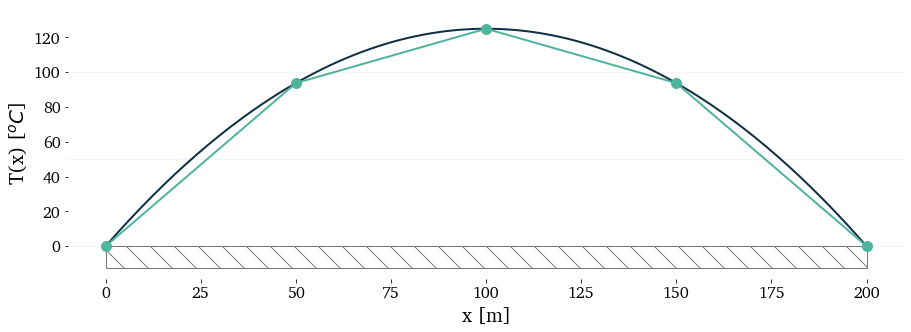

In [5]:
n_points = 5
x_FDM = np.linspace(0, L, n_points)
T_FDM = solve_with_fdm(n_points)

# Plot the numerical solution using FDM on top of the analytic solution:
plot_solution(x, T, x_FDM, T_FDM, FDM_color)
if save_plots==True: plt.savefig('../plots/example-heat-transfer-in-a-rod-FDM-n5.png', dpi = 500, bbox_inches='tight')

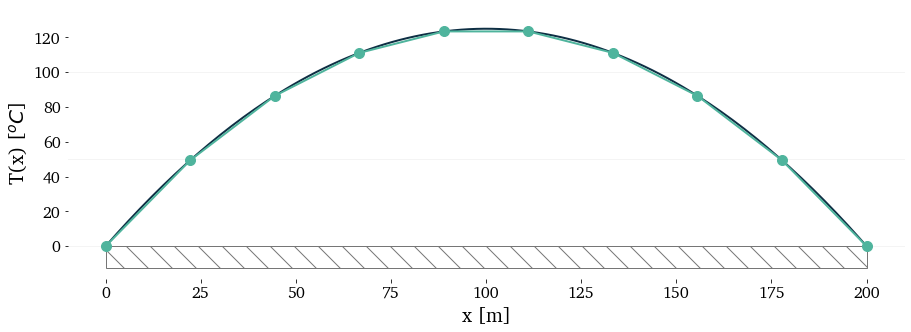

In [6]:
n_points = 10
x_FDM = np.linspace(0, L, n_points)
T_FDM = solve_with_fdm(n_points)

# Plot the numerical solution using FDM on top of the analytic solution:
plot_solution(x, T, x_FDM, T_FDM, FDM_color)
if save_plots==True: plt.savefig('../plots/example-heat-transfer-in-a-rod-FDM-n10.png', dpi = 500, bbox_inches='tight')

### Finite Volume Method (FVM)

***

# References

Below is a list of all learning materials that helped me put together this tutorial.

This material was adapted from material posted on the DelftX website, delftx.tudelft.nl, and created by TU Delft faculty members **Robert Mudde**, Professor of Multiphase Flow at the Dept. of Chemical Engineering and **Peter Hamersma**, Associate Professor at the Dept. of Chemical Engineering, 2015. DelftX is not responsible for any changes made to the original materials posted on its website and any such changes are the sole responsibility of Kamila Zdybał.

The course materials by Delft University of Technology are subjected to copyright and are licensed under a Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International [Licence](https://creativecommons.org/licenses/by-nc-sa/4.0/).

1. Robert Mudde, Peter Hamersma, *The Basics of Transport Phenomena*, Delft University of Technology, available on edX.org as DelftX: TP101x
2. Robert Mudde, Peter Hamersma, *Advanced Transport Phenomena*, Delft University of Technology, available on edX.org as DelftX: TP201x.
3. James C. Sutherland, [*Advanced Numerical Methods*](https://sutherland.che.utah.edu/teaching/chen6703/lectures-schedule/), The University of Utah, 2018
4. Joel H. Ferziger, Milovan Perić, Robert L. Street, *Computational Methods for Fluid Dynamics*, 3rd Edition, Springer-Verlag Berlin Heidelberg, 2002.